<center><h1>Restaurants sales</h1></center>

We have information about the restaurants sales of the one restaurant brand in 20 cities in 2010-2011. The task is to predict sales for 2012.

**Data:**
* restaurants.csv - list of 20 cities;
* data.csv - additional data about the cities, divided by week: temperature, fuel cost, unemployment rate, and whether the week is a holiday (restaurant traffic increases significantly on holiday weeks);
* train.csv - data on restaurant revenues grouped by city (there are several restaurants in one city);
* test.csv - test data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool

%matplotlib inline
np.random.seed(12)

Let's load and look at the available data.

In [2]:
data = pd.read_csv('data/data.csv', parse_dates=['Date'], dayfirst=True)
train = pd.read_csv('data/train.csv', parse_dates=['Date'], dayfirst=True)
test = pd.read_csv('data/test.csv', parse_dates=['Date'], dayfirst=True)
restaurants = pd.read_csv('data/restaurants.csv')

In [3]:
data.head()

,City,Date,Temperature,Fuel_Price,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,8.106,False
1,1,2010-02-12,38.51,2.548,8.106,True
2,1,2010-02-19,39.93,2.514,8.106,False
3,1,2010-02-26,46.63,2.561,8.106,False
4,1,2010-03-05,46.50,2.625,8.106,False


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3640 entries, 0 to 3639
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   City          3640 non-null   int64         
 1   Date          3640 non-null   datetime64[ns]
 2   Temperature   3640 non-null   float64       
 3   Fuel_Price    3640 non-null   float64       
 4   Unemployment  3380 non-null   float64       
 5   IsHoliday     3640 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1)
memory usage: 145.9 KB


In [5]:
data[data['Unemployment'].isna()]['Date'].min()

Timestamp('2013-05-03 00:00:00')

In [6]:
test['Date'].max()

Timestamp('2012-10-26 00:00:00')

The data file has some null values but the dates of these missing values are not present in either train or test, so they can be ignored.

In [7]:
restaurants.head()

,City,Size
0,1,151315
1,2,202307
2,3,37392
3,4,205863
4,5,34875


In [8]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   City    20 non-null     int64
 1   Size    20 non-null     int64
dtypes: int64(2)
memory usage: 448.0 bytes


There are no missing values in the city data.

In [9]:
train.head()

,City,Restaurant,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137938 entries, 0 to 137937
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   City          137938 non-null  int64         
 1   Restaurant    137938 non-null  int64         
 2   Date          137938 non-null  datetime64[ns]
 3   Weekly_Sales  137938 non-null  float64       
 4   IsHoliday     137938 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 4.3 MB


There are no missing valus in the restaurant data. Let's look at the `Weekly_Sales` distribution.

<AxesSubplot:ylabel='Frequency'>

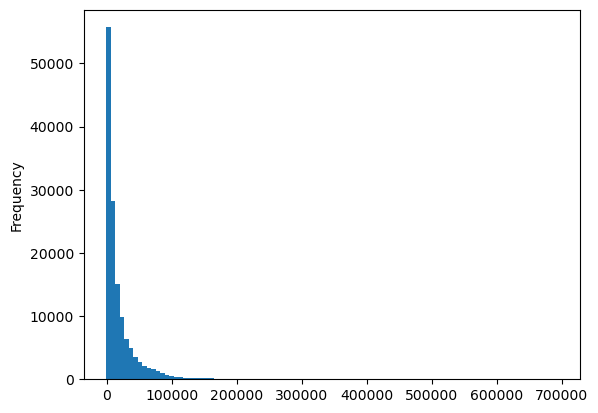

In [11]:
train['Weekly_Sales'].plot.hist(bins=100)

Most of the values are less than 200000. Let's take a closer look at the other values.

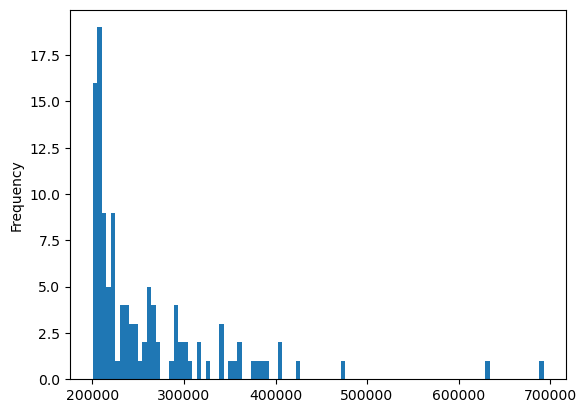

In [12]:
train.query('Weekly_Sales > 200000')['Weekly_Sales'].plot.hist(bins=100);

There are a few values in the data that are very different from the rest with values greater than 600000. Most likely they can be considered as outliers. Let's delete them.

In [13]:
train = train.query('Weekly_Sales < 600000')

The data represent the change in restaraunts' profits over time, so let's sort the data by date.

In [14]:
train.sort_values('Date', inplace=True)

If we look at the data collection dates of one restaurant, we can see that they are repeating. Therefore, to uniquely identify a restaurant, we should use the restaurant number and city number together.

In [15]:
train.query('Restaurant == 92')['Date'].value_counts()

2010-02-05    20
2011-04-22    20
2011-07-01    20
2011-06-24    20
2011-06-17    20
              ..
2010-09-03    20
2010-08-27    20
2010-08-20    20
2010-08-13    20
2011-12-30    20
Name: Date, Length: 100, dtype: int64

In [16]:
train.groupby(['City', 'Restaurant'])['Weekly_Sales'].describe()

count           mean           std        min          25%  \
City Restaurant                                                               
1    1           100.0   22978.995300  10200.388405   14537.37   16235.4025   
     2           100.0   45899.561300   3642.294223   35819.83   43734.5575   
     3           100.0   12758.939500   8359.919679    6165.73    8819.8775   
     4           100.0   36570.254000   3005.073562   32497.43   34604.6550   
     5           100.0   25068.999000  12880.958335   11570.27   17840.3100   
...                ...            ...           ...        ...          ...   
20   95          100.0  149705.708700  13808.575020  117238.26  140293.6750   
     96            2.0      -1.240000     10.182338      -8.44      -4.8400   
     97          100.0   25594.340200   3244.054879   18044.66   23232.5425   
     98          100.0   19374.990700   2500.456479   12470.88   18022.7200   
     99           17.0    1558.236471   3196.533129       0.01     100.0000   

                        50%          75%        max  
City Restaurant                                      
1    1            18988.700   23509.4700   57258.43  
     2            45235.020   47486.7125   65615.36  
     3            10141.660   12093.9425   51159.17  
     4            36372.335   37814.0400   47893.23  
     5            21409.925   26686.0450   85676.09  
...                     ...          ...        ...  
20   95          148548.720  158482.8975  184591.99  
     96              -1.240       2.3600       5.96  
     97           25454.595   28311.2050   33639.52  
     98           19075.465   20365.4050   28265.62  
     99             250.000     660.0000   12550.00  

[1522 rows x 8 columns]

The table shows that with this grouping, the minimum, average and maximum `Weekly_Sales` values of the restaurants can be very different.

Let's look at the sales graph of individual restaurants.

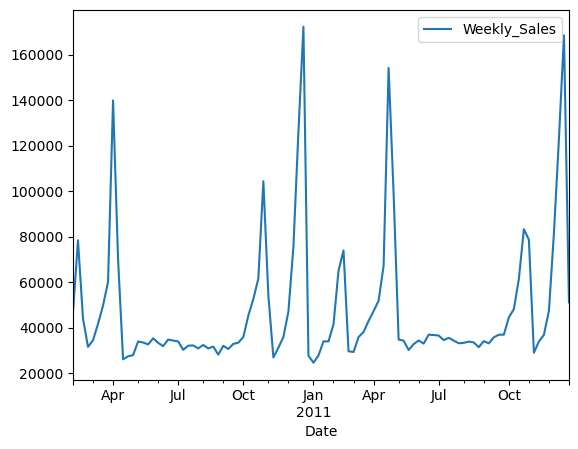

In [17]:
train.query('City==13 and Restaurant == 1').plot.line('Date', 'Weekly_Sales');

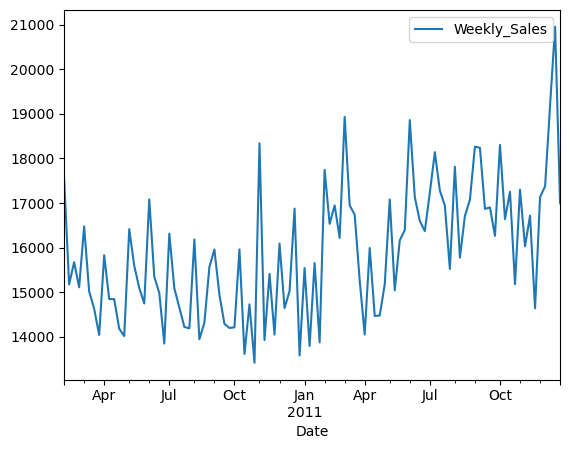

In [18]:
train.query('City==3 and Restaurant==2').plot.line('Date', 'Weekly_Sales');

On the first graph, the restaurant's sales is highly dependent on the month. This can be used as an additional feature.

Let's combine train, data and restaurants into one table.

In [19]:
def merge_data(df, data, restaurants):
    new_data = df.merge(data.drop('IsHoliday', axis=1), 'left', ['City', 'Date'])
    new_data = new_data.merge(restaurants, 'left', 'City')
    new_data['IsHoliday'] = new_data['IsHoliday'].astype(int)
    return new_data

In [20]:
train_data = merge_data(train, data, restaurants)
train_data.head()

,City,Restaurant,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,Unemployment,Size
0,1,1,2010-02-05,24924.50,0,42.31,2.572,8.106,151315
1,15,4,2010-02-05,11694.61,0,19.83,2.954,8.350,123737
2,8,30,2010-02-05,3280.50,0,34.14,2.572,6.299,155078
3,15,5,2010-02-05,18851.63,0,19.83,2.954,8.350,123737
4,1,59,2010-02-05,1409.34,0,42.31,2.572,8.106,151315


Let's train the first model as a starting point for future improvements comparison. I will use gradient boosting, namely CatBoosterRegressor. Gradient boosting models show good results on many problems and they are also used for regression. One of the pros of CatBoosterRegressor is the ability to show the importance of features, which can help to figure out where to go next.

In [21]:
CATEGORICAL_FEATURES = ['City', 'Restaurant']

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop(['Weekly_Sales', 'Date'], axis=1), train_data['Weekly_Sales'], train_size=.8)
train_pool = Pool(X_train, y_train, cat_features=CATEGORICAL_FEATURES)
valid_pool = Pool(X_valid, y_valid, cat_features=CATEGORICAL_FEATURES)

In [24]:
cbr_base = CatBoostRegressor(random_seed=12, iterations=2000, od_type='Iter', od_wait=30, use_best_model=True)
cbr_base.fit(train_pool, eval_set=valid_pool)

Learning rate set to 0.06982
0:	learn: 24715.4910000	test: 24841.8462415	best: 24841.8462415 (0)	total: 171ms	remaining: 5m 41s
1:	learn: 23841.9079048	test: 23977.1562420	best: 23977.1562420 (1)	total: 199ms	remaining: 3m 18s
2:	learn: 23052.5659338	test: 23193.9158200	best: 23193.9158200 (2)	total: 228ms	remaining: 2m 31s
3:	learn: 22350.8293769	test: 22495.6108810	best: 22495.6108810 (3)	total: 264ms	remaining: 2m 11s
4:	learn: 21719.1906436	test: 21868.6691345	best: 21868.6691345 (4)	total: 288ms	remaining: 1m 54s
5:	learn: 21161.4051723	test: 21318.8721859	best: 21318.8721859 (5)	total: 310ms	remaining: 1m 42s
6:	learn: 20652.7378052	test: 20813.0979344	best: 20813.0979344 (6)	total: 330ms	remaining: 1m 33s
7:	learn: 20196.2187634	test: 20357.2635500	best: 20357.2635500 (7)	total: 350ms	remaining: 1m 27s
8:	learn: 19801.9112577	test: 19964.7148460	best: 19964.7148460 (8)	total: 371ms	remaining: 1m 22s
9:	learn: 19447.0385413	test: 19610.8908754	best: 19610.8908754 (9)	total: 394ms

Let's look at the differences between the predicted and true values.

In [25]:
predicted = cbr_base.predict(valid_pool)

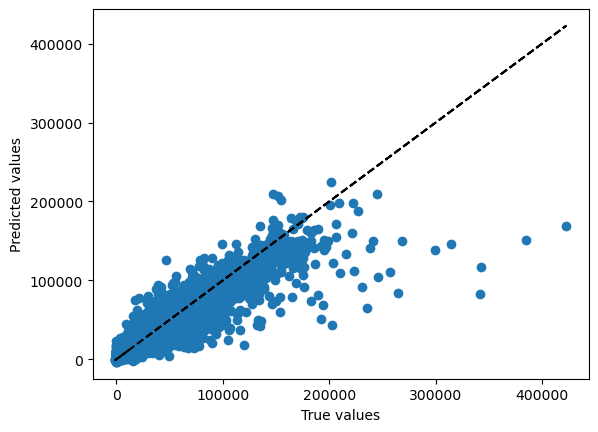

In [26]:
plt.scatter(y_valid, predicted)
plt.plot(y_valid, y_valid, '--k')
plt.xlabel('True values')
plt.ylabel('Predicted values');

The dots are mostly concentrated around the line, but not very densely. Larger values are significantly more distant.
Let's look at the feature importance.

In [27]:
for score, name in sorted(zip(cbr_base.feature_importances_, X_train.columns), reverse=True):
    print(f'{name}: {score}')

Restaurant: 49.13297724469362
Size: 14.77228250738383
City: 14.146476639287737
Fuel_Price: 7.723093854052109
Temperature: 7.292417782674497
Unemployment: 6.141572249774969
IsHoliday: 0.7911797221332489


Let's try to improve the quality of predictions by adding new features. As new features we can add:
- **Month** и **Day** - we cannot use the date directly, so we will add day and month numbers separately. There is no point in adding a year, as we will need to predict values for subsequent years;
- **Week** - since the data is collected by week, the week number may be relevant;
- **Mean**, **Min**, **Max**, **Median** - restaurants can have very different sales, so to reflect that we will add related features.

In [33]:
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day
train_data['Week'] = train_data['Date'].dt.isocalendar().week
train_data['Mean'] = train_data.groupby(['City', 'Restaurant'])['Weekly_Sales'].transform('mean')
train_data['Min'] = train_data.groupby(['City', 'Restaurant'])['Weekly_Sales'].transform('min')
train_data['Max'] = train_data.groupby(['City', 'Restaurant'])['Weekly_Sales'].transform('max')
train_data['Median'] = train_data.groupby(['City', 'Restaurant'])['Weekly_Sales'].transform('median')
train_data.head()

,City,Restaurant,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,Unemployment,Size,Month,Day,Week,Mean,Min,Max,Median
0,1,1,2010-02-05,24924.50,0,42.31,2.572,8.106,151315,2,5,5,22978.9953,14537.37,57258.43,18988.700
1,15,4,2010-02-05,11694.61,0,19.83,2.954,8.350,123737,2,5,5,13151.0809,10654.45,16610.51,12958.415
2,8,30,2010-02-05,3280.50,0,34.14,2.572,6.299,155078,2,5,5,2371.8054,1281.46,3584.80,2370.420
3,15,5,2010-02-05,18851.63,0,19.83,2.954,8.350,123737,2,5,5,18313.9461,7597.13,83150.97,14382.375
4,1,59,2010-02-05,1409.34,0,42.31,2.572,8.106,151315,2,5,5,1145.0824,126.46,18016.74,586.830


Let's train the model on the new features.

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop(['Weekly_Sales', 'Date'], axis=1), train_data['Weekly_Sales'], train_size=.8)
train_pool = Pool(X_train, y_train, cat_features=CATEGORICAL_FEATURES)
valid_pool = Pool(X_valid, y_valid, cat_features=CATEGORICAL_FEATURES)

In [36]:
cbr_1 = CatBoostRegressor(random_seed=12, iterations=2000, od_type='Iter', od_wait=30, use_best_model=True)
cbr_1.fit(train_pool, eval_set=valid_pool)

Learning rate set to 0.06982
0:	learn: 24256.1374501	test: 23939.8300535	best: 23939.8300535 (0)	total: 37.8ms	remaining: 1m 15s
1:	learn: 22856.7163682	test: 22545.6828516	best: 22545.6828516 (1)	total: 73.2ms	remaining: 1m 13s
2:	learn: 21547.9930484	test: 21247.6084274	best: 21247.6084274 (2)	total: 109ms	remaining: 1m 12s
3:	learn: 20355.8154201	test: 20061.1081657	best: 20061.1081657 (3)	total: 144ms	remaining: 1m 11s
4:	learn: 19243.6820185	test: 18950.2069615	best: 18950.2069615 (4)	total: 181ms	remaining: 1m 12s
5:	learn: 18230.5860885	test: 17939.3014717	best: 17939.3014717 (5)	total: 218ms	remaining: 1m 12s
6:	learn: 17291.6203411	test: 17007.2161174	best: 17007.2161174 (6)	total: 257ms	remaining: 1m 13s
7:	learn: 16438.4102100	test: 16162.6423082	best: 16162.6423082 (7)	total: 292ms	remaining: 1m 12s
8:	learn: 15624.6392511	test: 15350.9782426	best: 15350.9782426 (8)	total: 326ms	remaining: 1m 12s
9:	learn: 14878.7291596	test: 14617.5404870	best: 14617.5404870 (9)	total: 360

Let's look at the differences between the predicted and true values.

In [37]:
predicted = cbr_1.predict(valid_pool)

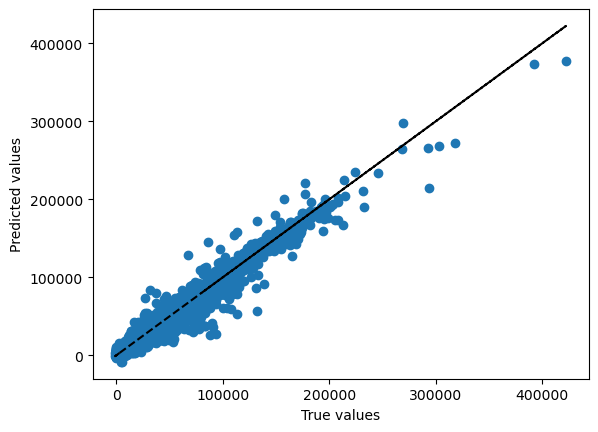

In [39]:
plt.scatter(y_valid, predicted)
plt.plot(y_valid, y_valid, '--k')
plt.xlabel('True values')
plt.ylabel('Predicted values');

The dots are grouped much closer to the line.

In [40]:
for score, name in sorted(zip(cbr_1.feature_importances_, X_train.columns), reverse=True):
    print(f'{name}: {score}')

Mean: 28.851202808906795
Week: 16.5376702406854
Median: 16.275706170088323
Max: 14.709707061482556
Min: 8.472472779824392
Day: 3.789946090778686
Restaurant: 2.833336470513064
IsHoliday: 2.5083199413940886
Month: 2.1141093975679053
Temperature: 1.6846318303837804
Fuel_Price: 0.788386346464011
Unemployment: 0.6936597953482867
Size: 0.4480650740920078
City: 0.2927859924706539


In [41]:
cbr_1.learning_rate_

0.06982000172138214

The model error continues to decrease. Let's increase the number of iterations and learning_rate.

In [42]:
cbr_2 = CatBoostRegressor(random_seed=12, iterations=3000, od_type='Iter', od_wait=30, use_best_model=True, learning_rate=.3)
cbr_2.fit(train_pool, eval_set=valid_pool)

0:	learn: 19390.7447812	test: 19116.1480589	best: 19116.1480589 (0)	total: 35ms	remaining: 1m 44s
1:	learn: 15107.7316125	test: 14850.5969482	best: 14850.5969482 (1)	total: 72.7ms	remaining: 1m 48s
2:	learn: 12214.7057407	test: 11979.5921596	best: 11979.5921596 (2)	total: 109ms	remaining: 1m 48s
3:	learn: 10461.3240670	test: 10260.8560217	best: 10260.8560217 (3)	total: 144ms	remaining: 1m 47s
4:	learn: 9174.8113505	test: 8996.6896996	best: 8996.6896996 (4)	total: 180ms	remaining: 1m 47s
5:	learn: 8356.0822477	test: 8228.9053340	best: 8228.9053340 (5)	total: 215ms	remaining: 1m 47s
6:	learn: 7768.6999783	test: 7709.0000181	best: 7709.0000181 (6)	total: 251ms	remaining: 1m 47s
7:	learn: 7368.2971407	test: 7358.5096166	best: 7358.5096166 (7)	total: 292ms	remaining: 1m 49s
8:	learn: 7116.7412434	test: 7153.2362867	best: 7153.2362867 (8)	total: 329ms	remaining: 1m 49s
9:	learn: 6863.3752030	test: 6906.9166005	best: 6906.9166005 (9)	total: 364ms	remaining: 1m 48s
10:	learn: 6686.2900488	test

The quality of the model stopped increasing with training.

In [43]:
predicted = cbr_2.predict(valid_pool)

Text(0, 0.5, 'Predicted values')

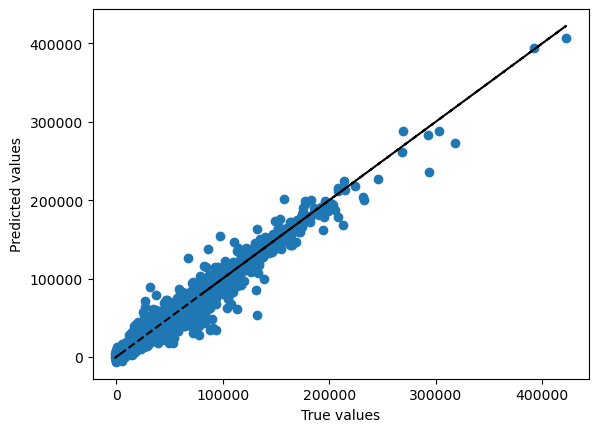

In [44]:
plt.scatter(y_valid, predicted)
plt.plot(y_valid, y_valid, '--k')
plt.xlabel('True values')
plt.ylabel('Predicted values');

The points have gotten a little closer to the line. Let's train the model on all data and use it to predict future data.

In [45]:
cbr_final = CatBoostRegressor(random_seed=12, iterations=3000, od_type='Iter', od_wait=30, learning_rate=.3)
all_data_pool = Pool(train_data.drop(['Weekly_Sales', 'Date'], 1), train_data['Weekly_Sales'], cat_features=CATEGORICAL_FEATURES)
cbr_final.fit(all_data_pool)

C:\Users\kostr\AppData\Local\Temp\ipykernel_20128\1694655306.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  all_data_pool = Pool(train_data.drop(['Weekly_Sales', 'Date'], 1), train_data['Weekly_Sales'], cat_features=CATEGORICAL_FEATURES)


0:	learn: 19369.0136760	total: 37.8ms	remaining: 1m 53s
1:	learn: 15005.8700647	total: 77ms	remaining: 1m 55s
2:	learn: 12021.1318039	total: 118ms	remaining: 1m 57s
3:	learn: 10186.0081149	total: 169ms	remaining: 2m 6s
4:	learn: 8944.8589008	total: 209ms	remaining: 2m 4s
5:	learn: 8135.3283012	total: 245ms	remaining: 2m 2s
6:	learn: 7564.3573858	total: 284ms	remaining: 2m 1s
7:	learn: 7204.0219273	total: 321ms	remaining: 1m 59s
8:	learn: 6927.0725006	total: 357ms	remaining: 1m 58s
9:	learn: 6740.0584751	total: 394ms	remaining: 1m 57s
10:	learn: 6608.6838674	total: 430ms	remaining: 1m 56s
11:	learn: 6533.3821697	total: 474ms	remaining: 1m 58s
12:	learn: 6417.1396189	total: 515ms	remaining: 1m 58s
13:	learn: 6357.1837703	total: 551ms	remaining: 1m 57s
14:	learn: 6259.5459705	total: 590ms	remaining: 1m 57s
15:	learn: 6236.2372518	total: 628ms	remaining: 1m 57s
16:	learn: 6155.8115770	total: 665ms	remaining: 1m 56s
17:	learn: 6103.2363534	total: 702ms	remaining: 1m 56s
18:	learn: 6038.6575

Transform the test data in the same way as the training data. Mean, Min, Max, Median will be taken from the corresponding restaurants in train_data.

In [47]:
test_data = merge_data(test, data, restaurants)
test_data['Month'] = test_data['Date'].dt.month
test_data['Day'] = test_data['Date'].dt.day
test_data['Week'] = test_data['Date'].dt.isocalendar().week
test_data = pd.merge(
    test_data, 
    train_data[['City', 'Restaurant', 'Mean', 'Min', 'Max', 'Median']].drop_duplicates(), 
    'left',
    ['City', 'Restaurant']
    )
test_data.drop('Date', axis=1, inplace=True)
test_data.head()

,City,Restaurant,IsHoliday,Temperature,Fuel_Price,Unemployment,Size,Month,Day,Week,Mean,Min,Max,Median
0,1,1,0,49.01,3.157,7.348,151315,1,6,1,22978.9953,14537.37,57258.43,18988.7
1,1,1,0,48.53,3.261,7.348,151315,1,13,2,22978.9953,14537.37,57258.43,18988.7
2,1,1,0,54.11,3.268,7.348,151315,1,20,3,22978.9953,14537.37,57258.43,18988.7
3,1,1,0,54.26,3.290,7.348,151315,1,27,4,22978.9953,14537.37,57258.43,18988.7
4,1,1,0,56.55,3.360,7.348,151315,2,3,5,22978.9953,14537.37,57258.43,18988.7


Get the predictions and write them to a file.

In [49]:
weekly_sales = cbr_final.predict(test_data)
weekly_sales = pd.Series(weekly_sales.reshape((-1,)), name='Weekly_Sales')
submission = pd.concat((test, weekly_sales), axis=1)
submission['Date'] = submission['Date'].dt.strftime('%d-%m-%y')
submission.to_csv('submission.csv', index=False)

In [50]:
submission.head()

,City,Restaurant,Date,IsHoliday,Weekly_Sales
0,1,1,06-01-12,False,17596.187291
1,1,1,13-01-12,False,18040.748895
2,1,1,20-01-12,False,20186.983226
3,1,1,27-01-12,False,19603.602903
4,1,1,03-02-12,False,25233.464635
